# 미니 프로젝트 1
### 초기화

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# header 없음 설정 참고사이트 https://rfriend.tistory.com/250
emnist_train = pd.read_csv('emnist-digits-train.csv', header = None)
emnist_test = pd.read_csv('emnist-digits-test.csv', header = None)

In [3]:
# balance 확인
emnist_train.iloc[:,0].value_counts().sort_index()

0    24000
1    24000
2    24000
3    24000
4    24000
5    24000
6    24000
7    24000
8    24000
9    24000
Name: 0, dtype: int64

In [4]:
emnist_train.shape

(240000, 785)

In [5]:
X_train = emnist_train.iloc[:,1:]    #images
y_train = emnist_train.iloc[:,0]    #target
X_test = emnist_test.iloc[:,1:]    #images
y_test = emnist_test.iloc[:,0]    #target
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [6]:
# 데이터 갯수 확인
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(240000, 784) (240000,)
(40000, 784) (40000,)


### Cross validation

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
ACCs = {}

In [8]:
%%time
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
scores = cross_val_score(forest_clf, X_train, y_train, n_jobs=-1, cv=10)
scores = np.round(scores, 4)
mean_acc = sum(scores/10)
print("Accuracy: ", scores)
print("Mean Accuracy: ", mean_acc)
ACCs['RF'] = mean_acc

Accuracy:  [0.9812 0.9805 0.982  0.9809 0.9801 0.9817 0.9826 0.9813 0.9806 0.9808]
Mean Accuracy:  0.9811700000000001
Wall time: 9min 1s


In [9]:
%%time
forest_clf_for_var_select = RandomForestClassifier(n_estimators=100,  n_jobs=-1, random_state=42)
forest_clf_for_var_select.fit(X_train, y_train)

Wall time: 1min 3s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [10]:
%%time
n_features = 400
important_features = pd.Series(forest_clf_for_var_select.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(n_features)
print("상위 %s개 feature 선택: %.4f의 importance를 가짐"%(n_features, important_features.sum()))      
X_train_top_features = X_train[important_features.index]
print("이하의 변수들이 선택됨")
print(important_features)

상위 400개 feature 선택: 0.9466의 importance를 가짐
이하의 변수들이 선택됨
265    0.007436
215    0.007362
515    0.006981
237    0.006909
238    0.006745
424    0.006631
214    0.006400
236    0.006174
264    0.006138
235    0.006050
425    0.005702
209    0.005647
543    0.005594
242    0.005546
488    0.005421
542    0.005390
570    0.005328
243    0.005239
188    0.005183
293    0.005180
514    0.005150
218    0.005027
397    0.004938
270    0.004891
321    0.004885
161    0.004835
378    0.004797
292    0.004778
213    0.004736
377    0.004634
         ...   
176    0.000946
511    0.000940
492    0.000931
256    0.000930
202    0.000924
414    0.000912
178    0.000912
678    0.000910
306    0.000903
385    0.000897
634    0.000896
330    0.000895
228    0.000892
418    0.000887
654    0.000883
556    0.000852
536    0.000843
507    0.000837
104    0.000819
205    0.000818
500    0.000814
658    0.000813
665    0.000808
152    0.000797
441    0.000792
636    0.000769
358    0.000768
655    0.000767


In [11]:
%%time
# 변수선택한 걸로 돌려보기 1
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100,  n_jobs=-1, random_state=42)
scores = cross_val_score(forest_clf, X_train_top_features, y_train, n_jobs=-1, cv=10)
scores = np.round(scores, 4)
mean_acc = sum(scores/10)
print("Accuracy: ", scores)
print("Mean Accuracy: ", mean_acc)
ACCs['RF_top'] = mean_acc

Accuracy:  [0.9808 0.9805 0.9811 0.9809 0.9795 0.9815 0.982  0.9815 0.9798 0.9812]
Mean Accuracy:  0.9808799999999999
Wall time: 8min 24s


In [20]:
%%time
# 변수선택한 걸로 돌려보기 2
from sklearn.linear_model import LogisticRegression
# 수렴문제로 일부 피쳐만 사용
n_features = 50
important_features = pd.Series(forest_clf_for_var_select.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(n_features)
print("상위 %s개 feature 선택: %.4f의 importance를 가짐"%(n_features, important_features.sum()))      

X_train_top_features = X_train[important_features.index]
reg_clf = LogisticRegression(multi_class='ovr', solver="liblinear", n_jobs=-1)
scores = cross_val_score(reg_clf, X_train_top_features, y_train, n_jobs=-1, cv=10)
scores = np.round(scores, 4)
mean_acc = sum(scores/10)
print("Accuracy: ", scores)
print("Mean Accuracy: ", mean_acc)
ACCs['Logit'] = mean_acc

상위 50개 feature 선택: 0.2550의 importance를 가짐
Accuracy:  [0.8311 0.8268 0.8317 0.8236 0.8248 0.8297 0.8291 0.8287 0.8241 0.827 ]
Mean Accuracy:  0.82766
Wall time: 44min 46s


In [22]:
print(ACCs)
print("best performance")
top_model = max(ACCs, key=ACCs.get)
top_model, ACCs[top_model]

{'RF': 0.9811700000000001, 'RF_top': 0.9808799999999999, 'Logit': 0.82766}
best performance


('RF', 0.9811700000000001)

### test set 성능

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [15]:
%%time
forest_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
forest_clf.fit(X_train, y_train)

Wall time: 1min 2s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [16]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, n_jobs=-1, cv=10)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[23771,     6,    17,    10,    63,    13,    48,     3,    55,
           14],
       [    1, 23795,    56,    23,    27,    10,    23,    24,    30,
           11],
       [   30,    11, 23646,    69,    41,     7,    21,    71,    92,
           12],
       [   23,    14,   166, 23366,    14,   122,     2,    96,   150,
           47],
       [   33,    13,    49,     2, 23594,     1,    38,    22,    34,
          214],
       [   45,    10,    27,   221,    27, 23451,    78,     8,    76,
           57],
       [   60,    23,    21,     4,    22,    84, 23754,     0,    32,
            0],
       [    4,    27,    90,    13,   120,     5,     2, 23491,    48,
          200],
       [   56,    65,    66,    79,   114,   131,    48,    14, 23254,
          173],
       [   35,    29,    21,   120,   194,    27,     4,   113,    99,
        23358]], dtype=int64)

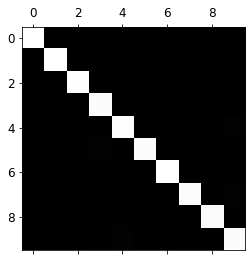

In [17]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

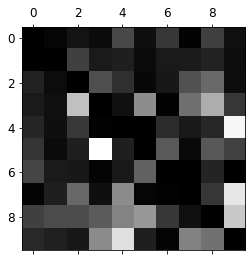

In [18]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [19]:
train_pred = forest_clf.predict(X_train)
train_acc = accuracy_score(train_pred, y_train)
print("Train acc: %.4f"%train_acc)

test_pred = forest_clf.predict(X_test)
test_acc = accuracy_score(test_pred, y_test)
print("Test acc: %.4f"%test_acc)
#https://subinium.github.io/basic-of-Evaluation/

Train acc: 1.0000
Test acc: 0.9820


다양한 분류 알고리즘과 특성 엔지니어링을 활용하여 분류기 성능 측정
* 다양한 분류 알고리즘(SGD, SVM, DT, RF, 그 외 Ensemble 등) 활용
* 특성 엔지니어링(단순 748픽셀 값이 아닌 자신만의 특성 추출 등) 활용
* 10-fold 교차 검증, 오차 행렬(confusion matrix)등을 활용해 분류기 성능 검증
* 최종적으로 테스트셋을 활용하여 일반화 오류 측정(정확도, accuracy 사용)
    - 알고리즘 학습에 절대로 테스트셋 활용 금지!(발견되면 0점 처리)

3번째 mnist강의자료가 도움이 됨.

https://www.kaggle.com/tonyqian/handwritten-capital-letter-recognition/notebook
***검색어: emnist kaggle ipynb
    
https://github.com/tensorflow/datasets/issues/812
참고